**This notebook consists of 6 sections:**

1) Set up and importing data

2) Coding and running technical indicators

3) Defining and coding buy and sell signal

4) (optional) Setting stop losses using supports and resistances (Risk management)

5) Results

# 1. Set up and importing data

In [151]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as pta
from datetime import date
from nsepy import get_history


Getting data from nsepy

In [152]:
sbin = get_history(symbol='SBIN',
                   start=date(2018,1,10),
                   end=date(2021,6,29))

Cleaning up the dataframe received from NSEPY
(Remove unwanted columns - Series, Prev Close, Trades, Turnover, VWAP, Last, %Deliverble)


In [153]:
del sbin['Series']
del sbin['Prev Close']
del sbin['Trades']
del sbin['%Deliverble']
del sbin['Turnover']
del sbin['VWAP']
del sbin['Last']
del sbin['Deliverable Volume']

### Visualizing data

In [154]:
sbin

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2018-01-10,SBIN,304.65,305.85,300.00,301.10,13064599
2018-01-11,SBIN,300.90,303.00,300.00,302.20,12299087
2018-01-12,SBIN,304.65,304.65,300.55,302.25,17594228
2018-01-15,SBIN,303.95,305.25,301.55,302.60,18189668
2018-01-16,SBIN,302.40,303.35,295.30,296.15,18040940
...,...,...,...,...,...,...
2021-06-23,SBIN,421.10,424.75,415.00,418.85,27564829
2021-06-24,SBIN,420.35,422.75,416.30,417.20,19214547
2021-06-25,SBIN,421.00,431.00,419.05,428.80,29886797


Here, the column indexes are  
Open = 1  
High = 2  
Low = 3  
Close = 4  
Volume = 5  
Candlesticks = 6  
Patterns = 7  
shorterEMA = 8
longerEMA = 9
MACD = 10
Signal Line = 11
RSI = 12
Balance = 13
Invested = 14
PnL = 15
Networth = 16

These will be required for coding the candlestick patterns and indicators, so that we can use the .iat[] .iloc[] indexers in python to locate and change cell values. These indexers only accept integer index values and do not accept label names.

In [155]:
def chart(df):
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Date')
    plt.ylabel('Price')
    df['Close'].plot(label='Closing prices', color='red')
    df['RSI'].plot(label='RSI', color = 'blue')
    df['MACD'].plot(label='MACD', color = 'green')

In [156]:
def candlechart(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

Candlestick chart demonstration

In [157]:
candlechart(sbin)

# 2. Coding and running technical indicators

For the indicators, I will be using 

1) Candlesticks\
    a) Shooting star\
    b) Bullish Marubozu\
    c) Bearish Marubozu

2) Technical Indicators\
    a) MACD\
    b) RSI\
    c) Volume (It is already present in the data from nsepy)

In [158]:
#Candlesticks

def label_cndl(df):
    df['Candlesticks'] = ""
    df['Patterns'] = "-"
    for i in range(len(df.index)):
        if df.iat[i, 4] < df.iat[i, 1]:
            df.iat[i, 6] = 'Red'
        elif df.iat[i, 4] > df.iat[i, 1]:
            df.iat[i, 6] = 'Green'

In [159]:
label_cndl(sbin)

In [160]:
sbin

,Symbol,Open,High,Low,Close,Volume,Candlesticks,Patterns
Date,,,,,,,,
2018-01-10,SBIN,304.65,305.85,300.00,301.10,13064599,Red,-
2018-01-11,SBIN,300.90,303.00,300.00,302.20,12299087,Green,-
2018-01-12,SBIN,304.65,304.65,300.55,302.25,17594228,Red,-
2018-01-15,SBIN,303.95,305.25,301.55,302.60,18189668,Red,-
2018-01-16,SBIN,302.40,303.35,295.30,296.15,18040940,Red,-
...,...,...,...,...,...,...,...,...
2021-06-23,SBIN,421.10,424.75,415.00,418.85,27564829,Red,-
2021-06-24,SBIN,420.35,422.75,416.30,417.20,19214547,Red,-
2021-06-25,SBIN,421.00,431.00,419.05,428.80,29886797,Green,-


Now, we have to mark the locations at which candlestick patterns have been found.

### Candlestick patterns coding

In [161]:
def shootingstar(df):
    '''Checking if the last two days were green candles, and the next two days are red candles. Also we look for a negligible body to wick ratio'''
    for i in range(len(df.index)-2):
        if((df.iat[i-2,6] == 'Green' and df.iat[i-1,6] == 'Green') and (df.iat[i+2,6] == 'Red' and df.iat[i+1,6] == 'Red')):
            if(df.iat[i,2] - df.iat[i,3] > 5*abs(df.iat[i,1]-df.iat[i,4])):
                df.iat[i,7]='Shooting Star'

def marubozu(df):
    ''' We are just checking if the body of the candle is 5 times larger than one of the wicks'''
    for i in range(len(df.index)):
        if df.iat[i, 6] == 'Green':
            if abs(df.iat[i, 1]-df.iat[i, 4]) > 5 * abs(df.iat[i,2] - df.iat[i,4]):
                df.iat[i, 7] = 'Bullish Marubozu'
        elif df.iat[i, 6] == 'Red':
            if abs(df.iat[i, 1]-df.iat[i, 4]) > 5 * abs(df.iat[i,1] - df.iat[i,3]):
                df.iat[i, 7] = 'Bearish Marubozu'
        

In [162]:
def label_ptrns(df):
    shootingstar(df)
    marubozu(df)
    
label_ptrns(sbin)

### Technical indicators coding

In [163]:
def MACD(df,shorter,longer):
    df['shorterEMA'] = df['Close'].ewm(span=shorter).mean()
    df['longerEMA'] = df['Close'].ewm(span=longer).mean()
    df['MACD'] = df['shorterEMA'] - df['longerEMA']
    df['Signal Line'] = df['MACD'].ewm(span=9).mean()
    
def RSI(df,days):
    df['RSI']=pta.rsi(df['Close'],length=days)
    
def indicators(df):
    MACD(df, 12, 26)
    RSI(df, 14)
    
#To customize the period, use the MACD and RSI methods instead of indicators method

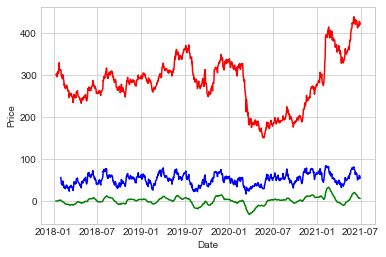

In [164]:
indicators(sbin)
chart(sbin)

# 3. Setting up buy and sell signals

#### Buy signals:
We will go long if
1) Bullish MACD crossover occurs  
2) RSI is in our favour  

We will increase our investment if volume increases drastically while the market is still moving in our favour 

#### Sell signals:
We will short if 
1) Bearish MACD crossover occurs  
2) RSI is in our favour  

We will short more if volume increases drastically while the market is still moving in our favour

#### Costs:
Transaction costs: 0.03%
Tax: 15% of profits

In [165]:
sbin

,Symbol,Open,High,Low,Close,Volume,Candlesticks,Patterns,shorterEMA,longerEMA,MACD,Signal Line,RSI
Date,,,,,,,,,,,,,
2018-01-10,SBIN,304.65,305.85,300.00,301.10,13064599,Red,-,301.100000,301.100000,0.000000,0.000000,NaN
2018-01-11,SBIN,300.90,303.00,300.00,302.20,12299087,Green,-,301.695833,301.671154,0.024679,0.013711,NaN
2018-01-12,SBIN,304.65,304.65,300.55,302.25,17594228,Red,-,301.912125,301.879128,0.032997,0.021615,NaN
2018-01-15,SBIN,303.95,305.25,301.55,302.60,18189668,Red,-,302.129260,302.080652,0.048608,0.030759,NaN
2018-01-16,SBIN,302.40,303.35,295.30,296.15,18040940,Red,-,300.504716,300.705309,-0.200593,-0.038063,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23,SBIN,421.10,424.75,415.00,418.85,27564829,Red,-,421.591747,414.343649,7.248097,11.108623,54.477252
2021-06-24,SBIN,420.35,422.75,416.30,417.20,19214547,Red,-,420.916093,414.555231,6.360862,10.159071,52.971133
2021-06-25,SBIN,421.00,431.00,419.05,428.80,29886797,Green,-,422.129002,415.610399,6.518603,9.430977,61.111190


In [199]:
def portfolio(df):
    df['Balance'] = 100000
    df['Invested'] = 0
    df['PnL'] = 0
    df['Networth'] = 0
    return df    
portfolio(sbin)
##########################################################################
#All the functions related to current trades

def afterTransaction(amt):
    return amt*0.9997

def cashOut(perc, df, i):
    df.iloc[i,13] = df.iloc[i-1,13] + afterTransaction(df.iloc[i,15] * perc/100)
    df.iloc[i,14] = df.iloc[i-1,15] * (1- perc/100)
    df.iloc[i,15] = 0
    print('cashOut has been called')
    return df

def isCurrentRSIok(df, i):
    if df.iloc[i,14] > 0 and df.iat[i, 12] > 70:
        cashOut(100, df, i)
    if df.iloc[i,14] < 0 and df.iat[i, 12] <30:
        cashOut(100, df, i)
    return df
# def patternCheck(df, df.at[i, 'df.iloc[i,13]ance'], df.iloc[i,14], df.at[i,'df.iloc[i,15]']):
#     if df.iat(i, 7) = 'Shooting Star':
#         if df.iloc[i,14] > 0:
#             if df.iloc[i,15] > 0:
#                 cashOut(80,df)
#             else:
#                 cashOut(100,df)
#     if df.iat(i, 7) = 'Bullish Marubozu':
#         if df.iloc[i,14] > 0:
#             buyIn()
#         else:
#             cashOut()
#     if df.iat(i, 7) = 'Bearish Marubozu':
#         if df.iloc[i,14] < 0:
#             buyIn()
#         else:
#             cashOut()

def volumeCheck(df, i):
    if (1 - df.iat[i, 5] / df.iat[i-1, 5]) > 0.1:
        if df.iat[i, 6] == 'Green' and df.iloc[i,14] > 0:
            df.iloc[i,13] = df.iloc[i-1,13] * 0.5
            df.iloc[i,14] = df.iloc[i-1,14] +df.iloc[i,13] * 0.5
            print('Volume based trade')
    return df

def currentTrades(df, i):
#     print(df.at['2021-06-24', 'PnL'])
    df.iloc[i,15] = df.iloc[i-1,15] + df.iloc[i,14] * (1 - df.iat[i,1] / df.iat[i-1,4])
    if df.iloc[i,15] > 1.30*df.iloc[i-1,14]:
        if df.iloc[i,15] > 25000:
            cashOut(75,df,i)
        else:
            cashOut(100,df,i)
#   patternCheck(df, df.at[i, 'df.iloc[i,13]ance'], df.iloc[i,14], df.at[i,'df.iloc[i,15]'])
    isCurrentRSIok(df, i)
    volumeCheck(df, i)
    return df

##########################################################################
#All the functions related to new trades


def goLongPerc(perc, df, i):
    print('goLongPerc has been called')
    df.iloc[i,13] = df.iloc[i-1,13] * (1 - perc/100)
    df.iloc[i,14] = df.iloc[i-1,14] + afterTransaction(df.iloc[i,13] * perc/100)
    return df

def goShortPerc(perc, df, i):
    print('goShortPerc has been called')
    if df.iloc[i,13] * (1-perc/100) > 20000:
        df.iloc[i,13] = df.iloc[i-1,13] * (1 + perc/100)
        df.iloc[i,14] = df.iloc[i-1,14] - afterTransaction(df.iloc[i,13] * perc/100)
    return df

def goShort(df, i):
    print('goShort has been called')
    if df.iloc[i,13] > 20000:
        df.iloc[i,13] = df.iloc[i-1,13] + afterTransaction(20000)
        df.iloc[i,14] = df.iloc[i-1,14] - 20000
    else:
        df.iloc[i,14] = df.iloc[i-1,14] - afterTransaction(df.iloc[i,13]) 
        df.iloc[i,13] = df.iloc[i-1,13] + afterTransaction(df.iloc[i,13])
    return df

def goLong(df,i):
    print('goLong has been called')
    if df.iloc[i,13] > 20000:
        df.iloc[i,13] = df.iloc[i-1,13] - 20000
        df.iloc[i,14] = df.iloc[i-1,14] + afterTransaction(20000)
    else:
        df.iloc[i,14] = df.iloc[i-1,14] + afterTransaction(df.iloc[i,13]) 
        df.iloc[i,13] = 0
    return df

def MACDcheck(df,i):
#     if MACD just goes above signal line, bullish, buy
#     if MACD just goes below signal line, bearish, sell
    if df.iat[i, 10] - df.iat[i, 11] > 0 and df.iat[i-1, 10] - df.iat[i-1, 11] < 0:
        return 'Buy signal'
    if df.iat[i, 10] - df.iat[i, 11] < 0 and df.iat[i-1, 10] - df.iat[i-1, 11] > 0:
        return 'Sell signal'
        
def RSIcheck(df,i):
#     if RSI is 70+ and you want to sell, go ahead and sell
#     if RSI is 30- and you want to buy, go ahead and buy
    if df.iat[i, 12] >= 70:
        return 'Sell signal'
    if df.iat[i, 12] <= 30:
        return 'Buy signal'
    

def newTrades(df, i):
    cashOutPercentage = 100
    #Default cash out percentage is 100
    #if df.iloc[i,14] >= 0:
    if True:
        if MACDcheck(df,i) == 'Buy signal' and MACDcheck(df,i) == 'Buy signal':
            goLong(df,i)
        elif MACDcheck(df,i) == 'Sell signal' and MACDcheck(df,i) == 'Sell signal':
            cashOut(cashOutPercentage,df,i)
    else:
        if MACDcheck(df,i) == 'Buy signal' and MACDcheck(df,i) == 'Buy signal':
            cashOut(cashOutPercentage,df,i)
        elif MACDcheck(df,i) == 'Sell signal' and MACDcheck(df,i) == 'Sell signal':
            goShort(df,i)
##########################################################################
def trade(df):
    for i in range(len(df.index)): 
        df.iloc[i,13]=df.iloc[i-1,13]
        df.iloc[i,14]=df.iloc[i-1,14]
        df.iloc[i,15]=df.iloc[i-1,15]
        df.iloc[i,16]=df.iloc[i-1,16]
        currentTrades(df,i)
        newTrades(df,i)
        df.iloc[i,16] = df.iloc[i,15] + df.iloc[i,13]
        
        print(df.iloc[i,13],df.iloc[i,14],df.iloc[i,15],df.iloc[i,16])
        
trade(sbin)

100000 0 0.0 100000.0
100000 0 0.0 100000.0
100000 0 0.0 100000.0
100000 0 0.0 100000.0
cashOut has been called
100000.0 0.0 0.0 100000.0
goLong has been called
80000.0 19994.0 0.0 80000.0
80000.0 19994.0 -514.3360468902619 79485.66395310973
Volume based trade
40000.0 39994.0 -560.4887261977647 39439.511273802236
40000.0 39994.0 -444.09551682024045 39555.90448317976
40000.0 39994.0 -431.0469034434042 39568.953096556594
40000.0 39994.0 -380.7558000168034 39619.24419998319
40000.0 39994.0 -726.263226509684 39273.73677349032
40000.0 39994.0 -726.263226509684 39273.73677349032
40000.0 39994.0 -719.8559852408571 39280.14401475914
Volume based trade
20000.0 49994.0 -649.7022617517795 19350.29773824822
cashOut has been called
18768.13556490441 -0.0 0.0 18768.13556490441
18768.13556490441 -0.0 0.0 18768.13556490441
18768.13556490441 -0.0 0.0 18768.13556490441
18768.13556490441 -0.0 0.0 18768.13556490441
18768.13556490441 -0.0 0.0 18768.13556490441
18768.13556490441 -0.0 0.0 18768.13556490441
1

-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
-1.328737572404554e-09 0.0 0.0 -1.328737572404554e-09
goLong has been called
0.0 -1.3283389511328326e-09 0.0 0.0
cashOut has been called
4.591771955212614e-13 0.0 0.0 4.591771955212614e-13
4.591771955212614e-13 0.0 0.0 4.591771955212614e-13
4.591771955212614e-13 0.0 0.0 4.591771955212614e-13
4.591771955212614e-13 0.0 0.0 4.591771955212614e-13
4.591771955212614e-13 0.0 0.0 4.591771955212614e-13
4.591771955212614e-13 0.0 0.0 4.591771955212614e-13
4.591771955212614e-13 0.0 0.0 4.591771955212614e-13
4.59177195521

1.2020794064789857e-26 0.0 0.0 1.2020794064789857e-26
goLong has been called
0.0 1.201718782657042e-26 0.0 0.0
Volume based trade
0.0 1.201718782657042e-26 4.753455346731574e-29 4.753455346731574e-29
Volume based trade
0.0 1.201718782657042e-26 1.4110148238582169e-29 1.4110148238582169e-29
0.0 1.201718782657042e-26 3.0036899885182798e-30 3.0036899885182798e-30
0.0 1.201718782657042e-26 -2.0991420937652811e-29 -2.0991420937652811e-29
0.0 1.201718782657042e-26 -1.7206463932882507e-28 -1.7206463932882507e-28
0.0 1.201718782657042e-26 -3.171842934234407e-28 -3.171842934234407e-28
0.0 1.201718782657042e-26 -3.7475421381332657e-28 -3.7475421381332657e-28
0.0 1.201718782657042e-26 -4.753791608735121e-28 -4.753791608735121e-28
0.0 1.201718782657042e-26 -6.183915720555345e-28 -6.183915720555345e-28
Volume based trade
0.0 1.201718782657042e-26 -6.183915720555345e-28 -6.183915720555345e-28
0.0 1.201718782657042e-26 -7.122908231322295e-28 -7.122908231322295e-28
cashOut has been called
-6.967878165

cashOut has been called
5.2144456809372255e-33 0.0 0.0 5.2144456809372255e-33
5.2144456809372255e-33 0.0 0.0 5.2144456809372255e-33
5.2144456809372255e-33 0.0 0.0 5.2144456809372255e-33
5.2144456809372255e-33 0.0 0.0 5.2144456809372255e-33
5.2144456809372255e-33 0.0 0.0 5.2144456809372255e-33
goLong has been called
0.0 5.212881347232944e-33 0.0 0.0
0.0 5.212881347232944e-33 -2.793788868315252e-35 -2.793788868315252e-35
Volume based trade
0.0 5.212881347232944e-33 4.125965132436396e-35 4.125965132436396e-35
0.0 5.212881347232944e-33 -4.5998746924420577e-35 -4.5998746924420577e-35
Volume based trade
0.0 5.212881347232944e-33 -4.1400498161791964e-35 -4.1400498161791964e-35
0.0 5.212881347232944e-33 -1.1029320319130277e-34 -1.1029320319130277e-34
0.0 5.212881347232944e-33 -1.1029320319130277e-34 -1.1029320319130277e-34
0.0 5.212881347232944e-33 -1.8516940754684598e-34 -1.8516940754684598e-34
0.0 5.212881347232944e-33 -4.405395267936137e-34 -4.405395267936137e-34
0.0 5.212881347232944e-33 -

-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
cashOut has been called
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
-3.282481784711003e-46 0.0 0.0 -3.282481784711003e-46
goLong has been called
0.0 -3.2814970401755898e-46 0.0 0.0

#### Function to visualize profit or loss made over time 

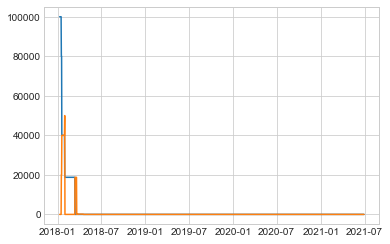

In [200]:
%matplotlib inline 

def plotter(df):
    x = df.index
    y1 = df['Balance']
    y2 = df['Invested']

    plt.plot(x, y1)
    plt.plot(x,y2)

plotter(sbin)